In [1]:
import numpy as np 
import pandas as pd 
import os 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from PIL import Image
import glob
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from PIL import Image

In [2]:
images = []
mask = glob.glob("C:\ML projects\Breast Cancer Segmentation\data/*/*_mask.png")
for i in mask:
    images.append(i.replace('_mask',''))

In [3]:
print(images[:5])
print('-------------------')
print(mask[:5])

['C:\\ML projects\\Breast Cancer Segmentation\\data\\benign\\benign (1).png', 'C:\\ML projects\\Breast Cancer Segmentation\\data\\benign\\benign (10).png', 'C:\\ML projects\\Breast Cancer Segmentation\\data\\benign\\benign (100).png', 'C:\\ML projects\\Breast Cancer Segmentation\\data\\benign\\benign (101).png', 'C:\\ML projects\\Breast Cancer Segmentation\\data\\benign\\benign (102).png']
-------------------
['C:\\ML projects\\Breast Cancer Segmentation\\data\\benign\\benign (1)_mask.png', 'C:\\ML projects\\Breast Cancer Segmentation\\data\\benign\\benign (10)_mask.png', 'C:\\ML projects\\Breast Cancer Segmentation\\data\\benign\\benign (100)_mask.png', 'C:\\ML projects\\Breast Cancer Segmentation\\data\\benign\\benign (101)_mask.png', 'C:\\ML projects\\Breast Cancer Segmentation\\data\\benign\\benign (102)_mask.png']


In [4]:
data = pd.DataFrame({'images':images,'masks':mask})
data.head(9)

images   
0  C:\ML projects\Breast Cancer Segmentation\data...  \
1  C:\ML projects\Breast Cancer Segmentation\data...   
2  C:\ML projects\Breast Cancer Segmentation\data...   
3  C:\ML projects\Breast Cancer Segmentation\data...   
4  C:\ML projects\Breast Cancer Segmentation\data...   
5  C:\ML projects\Breast Cancer Segmentation\data...   
6  C:\ML projects\Breast Cancer Segmentation\data...   
7  C:\ML projects\Breast Cancer Segmentation\data...   
8  C:\ML projects\Breast Cancer Segmentation\data...   

                                               masks  
0  C:\ML projects\Breast Cancer Segmentation\data...  
1  C:\ML projects\Breast Cancer Segmentation\data...  
2  C:\ML projects\Breast Cancer Segmentation\data...  
3  C:\ML projects\Breast Cancer Segmentation\data...  
4  C:\ML projects\Breast Cancer Segmentation\data...  
5  C:\ML projects\Breast Cancer Segmentation\data...  
6  C:\ML projects\Breast Cancer Segmentation\data...  
7  C:\ML projects\Breast Cancer Segmentation\data...  
8  C:\ML projects\Breast Cancer Segmentation\data...

In [5]:
data.shape

(780, 2)

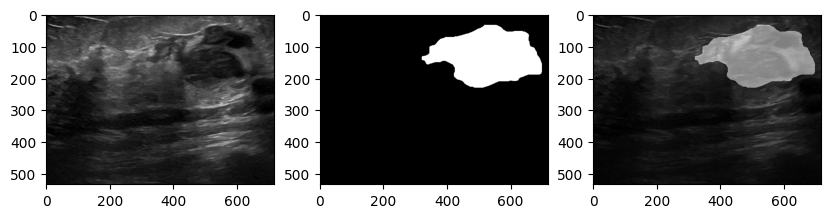

In [7]:
import cv2 
N=600
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
img=cv2.imread(data.images.iloc[N])
plt.imshow(img)
plt.subplot(1,3,2)
msk=cv2.imread(data.masks.iloc[N])
plt.imshow(msk)
plt.subplot(1,3,3)
plt.imshow(img)
plt.imshow(msk,alpha=0.5)

In [9]:
data_train,data_test=train_test_split(data,test_size=0.1)

data_train,data_val=train_test_split(data_train,test_size=0.05)

In [10]:
datagen = ImageDataGenerator(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest',
                            rescale=1./255)

In [11]:
image_train=datagen.flow_from_dataframe(data_train,  
                                    target_size=(256,256), 
                                    color_mode='rgb',
                                    shuffle=True,
                                    seed=42,
                                    x_col ="images", 
                                    batch_size=32,
                                    class_mode=None
                                    
)
mask_train=datagen.flow_from_dataframe(data_train, 
                                    target_size=(256,256), 
                                    color_mode='grayscale',
                                    shuffle=True,
                                    seed=42,
                                    x_col ="masks", 
                                    batch_size=32,
                                    class_mode=None
)

Found 666 validated image filenames.
Found 666 validated image filenames.


In [12]:
image_validation=datagen.flow_from_dataframe(data_val,  
                                    target_size=(256,256), 
                                    color_mode='rgb',
                                    shuffle=True,
                                    seed=42,
                                    x_col ="images", 
                                    batch_size=32,
                                    class_mode=None
)

mask_validation=datagen.flow_from_dataframe(data_val, 
                                    target_size=(256,256), 
                                    color_mode='grayscale',
                                    shuffle=True,
                                    seed=42,
                                    x_col ="masks", 
                                    batch_size=32,
                                    class_mode=None
)

Found 36 validated image filenames.
Found 36 validated image filenames.


In [13]:
train_gen=zip(image_train,mask_train)
valid_gen=zip(image_validation,mask_validation)

In [14]:
def unet(input_size=(256,256,3)):
    inputs = layers.Input(input_size)
    
    conv1 = layers.Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = layers.Activation('relu')(conv1)
    conv1 = layers.Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = layers.BatchNormalization(axis=3)(conv1)
    bn1 = layers.Activation('relu')(bn1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = layers.Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = layers.Activation('relu')(conv2)
    conv2 = layers.Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = layers.BatchNormalization(axis=3)(conv2)
    bn2 = layers.Activation('relu')(bn2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = layers.Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = layers.Activation('relu')(conv3)
    conv3 = layers.Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = layers.BatchNormalization(axis=3)(conv3)
    bn3 = layers.Activation('relu')(bn3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = layers.Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = layers.Activation('relu')(conv4)
    conv4 = layers.Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = layers.BatchNormalization(axis=3)(conv4)
    bn4 = layers.Activation('relu')(bn4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = layers.Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = layers.Activation('relu')(conv5)
    conv5 = layers.Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = layers.BatchNormalization(axis=3)(conv5)
    bn5 = layers.Activation('relu')(bn5)

    up6 = layers.concatenate([layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = layers.Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = layers.Activation('relu')(conv6)
    conv6 = layers.Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = layers.BatchNormalization(axis=3)(conv6)
    bn6 = layers.Activation('relu')(bn6)

    up7 = layers.concatenate([layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = layers.Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = layers.Activation('relu')(conv7)
    conv7 = layers.Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = layers.BatchNormalization(axis=3)(conv7)
    bn7 = layers.Activation('relu')(bn7)

    up8 = layers.concatenate([layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = layers.Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = layers.Activation('relu')(conv8)
    conv8 = layers.Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = layers.BatchNormalization(axis=3)(conv8)
    bn8 = layers.Activation('relu')(bn8)

    up9 = layers.concatenate([layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = layers.Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = layers.Activation('relu')(conv9)
    conv9 = layers.Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = layers.BatchNormalization(axis=3)(conv9)
    bn9 = layers.Activation('relu')(bn9)

    conv10 = layers.Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return models.Model(inputs=[inputs], outputs=[conv10])

In [15]:
smooth=1
def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

In [16]:
model = unet(input_size=(256, 256, 3))

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                             

 ose)                                                                                             
                                                                                                  
 concatenate (Concatenate)      (None, 32, 32, 1024  0           ['conv2d_transpose[0][0]',       
                                )                                 'conv2d_7[0][0]']               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 32, 32, 512)  4719104     ['concatenate[0][0]']            
                                                                                                  
 activation_10 (Activation)     (None, 32, 32, 512)  0           ['conv2d_10[0][0]']              
                                                                                                  
 conv2d_11 (Conv2D)             (None, 32, 32, 512)  2359808     ['activation_10[0][0]']          
          

In [18]:
model.compile(
    optimizer='adam',
    loss=bce_dice_loss,
    metrics=[dice_coef,'accuracy'])

In [19]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=100,
    validation_steps=len(data_val) /32,
    steps_per_epoch=len(data_train) /32
)

Epoch 1/100


C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


NotFoundError: Graph execution error:

Detected at node 'model/activation_4/Relu' defined at (most recent call last):
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\b3nni\AppData\Local\Temp\ipykernel_21860\1410565014.py", line 1, in <module>
      history = model.fit(
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\keras\layers\core\activation.py", line 59, in call
      return self.activation(inputs)
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'model/activation_4/Relu'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16781824 bytes.
  Profiling failure on CUDNN engine 1: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16781824 bytes.
  Profiling failure on CUDNN engine 0#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 0: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 2#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 620756992 bytes.
  Profiling failure on CUDNN engine 2: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 620756992 bytes.
  Profiling failure on CUDNN engine 4#TC: RESOURCE_EXHAUSTED: Allocating 4908515328 bytes exceeds the memory limit of 4294967296 bytes.
  Profiling failure on CUDNN engine 4: RESOURCE_EXHAUSTED: Allocating 4908515328 bytes exceeds the memory limit of 4294967296 bytes.
  Profiling failure on CUDNN engine 6#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 20056064 bytes.
  Profiling failure on CUDNN engine 6: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 20056064 bytes.
  Profiling failure on CUDNN engine 5#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 266338304 bytes.
  Profiling failure on CUDNN engine 5: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 266338304 bytes.
  Profiling failure on CUDNN engine 7#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 474480640 bytes.
  Profiling failure on CUDNN engine 7: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 474480640 bytes.
	 [[{{node model/activation_4/Relu}}]] [Op:__inference_train_function_4445]

In [69]:
eval_results = model.evaluate(valid_gen, steps=len(data_val) /32, verbose=1)

2/2 [==============================] - 3s 2s/step - loss: 0.7744 - dice_coef: 0.5809 - accuracy: 0.9093        


1/1 [==============================] - 0s 28ms/step


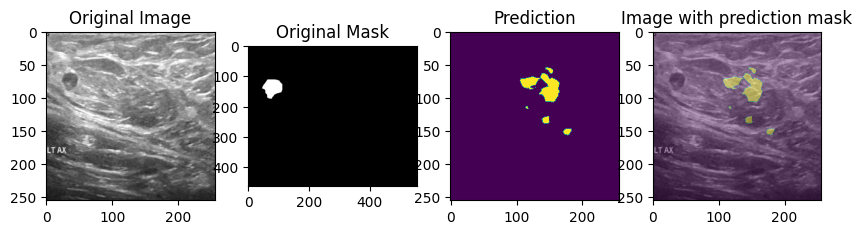

1/1 [==============================] - 0s 28ms/step


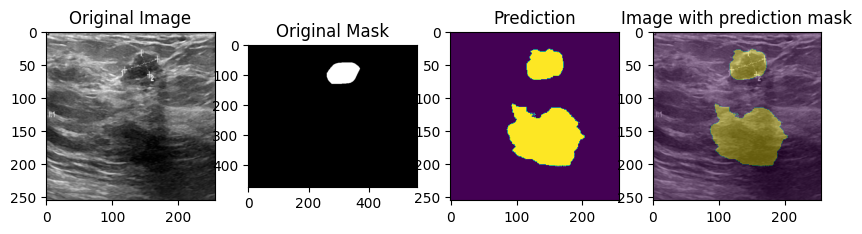

1/1 [==============================] - 0s 25ms/step


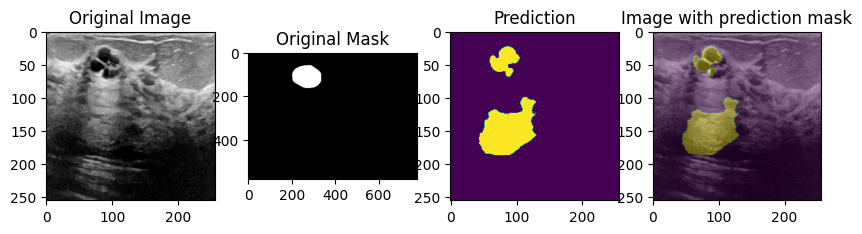

1/1 [==============================] - 0s 25ms/step


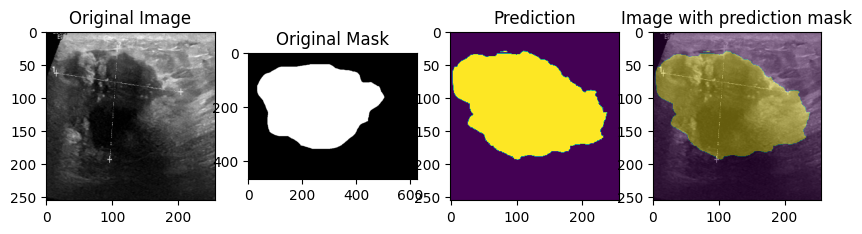

1/1 [==============================] - 0s 42ms/step


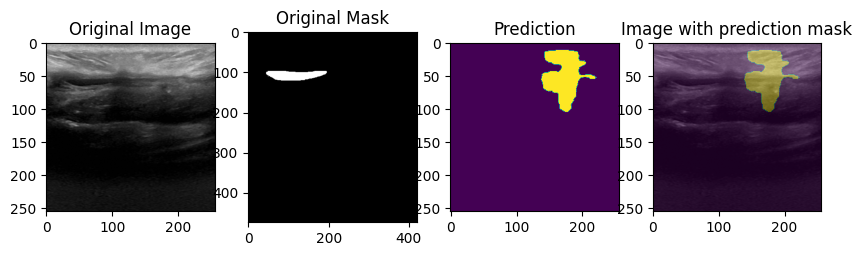

1/1 [==============================] - 0s 36ms/step


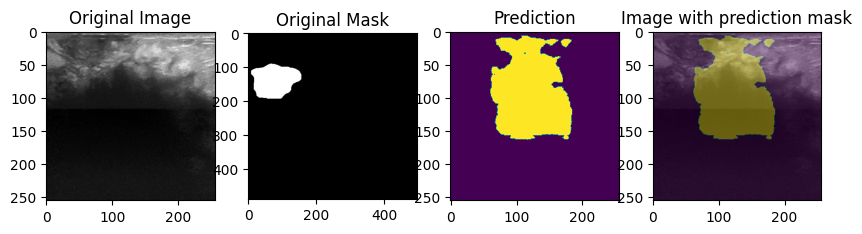

1/1 [==============================] - 0s 28ms/step


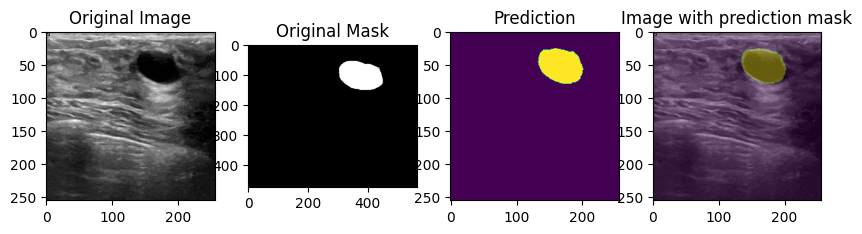

1/1 [==============================] - 0s 29ms/step


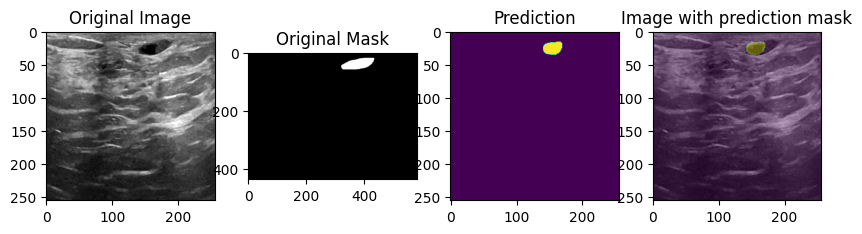

1/1 [==============================] - 0s 31ms/step


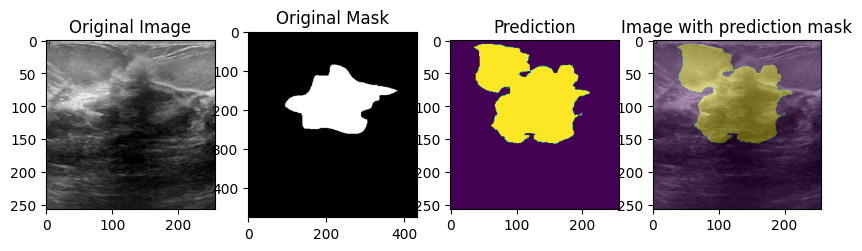

1/1 [==============================] - 0s 30ms/step


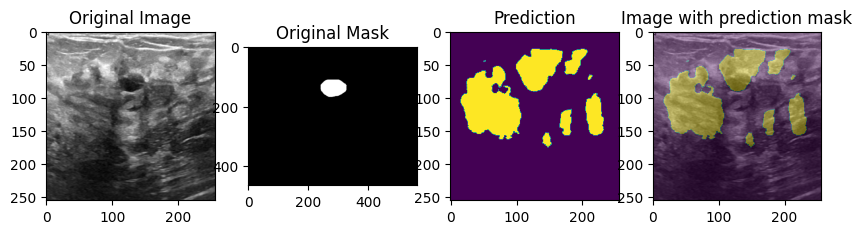

1/1 [==============================] - 0s 26ms/step


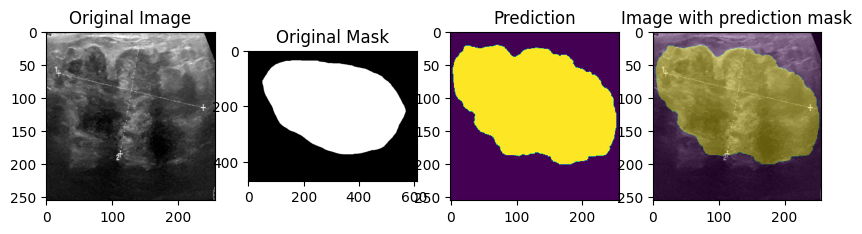

1/1 [==============================] - 0s 27ms/step


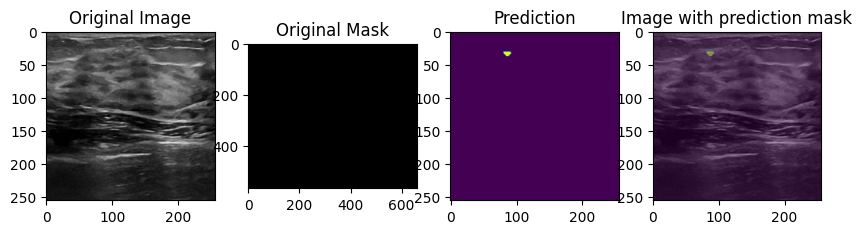

1/1 [==============================] - 0s 27ms/step


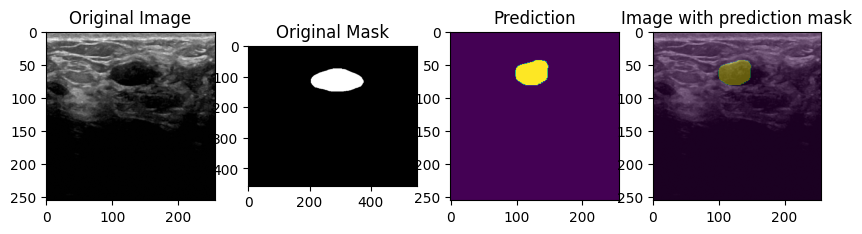

1/1 [==============================] - 0s 26ms/step


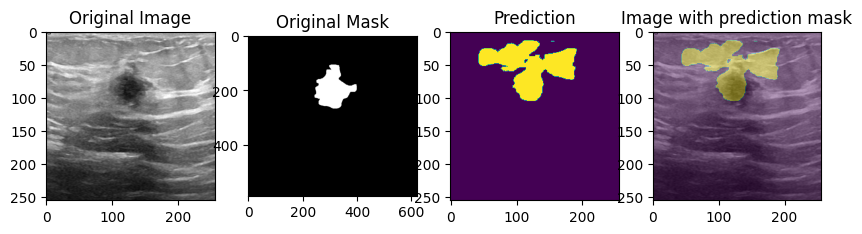

1/1 [==============================] - 0s 27ms/step


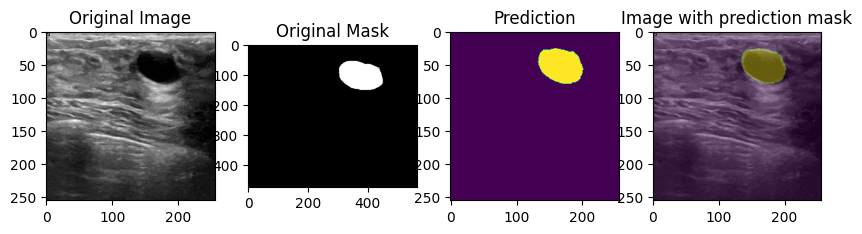

1/1 [==============================] - 0s 26ms/step


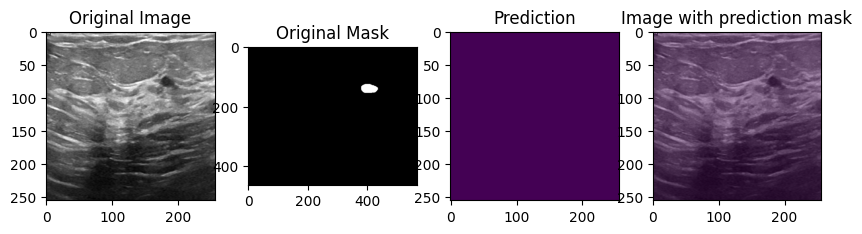

1/1 [==============================] - 0s 26ms/step


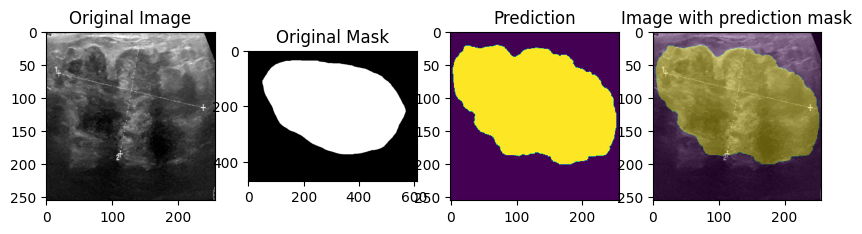

1/1 [==============================] - 0s 25ms/step


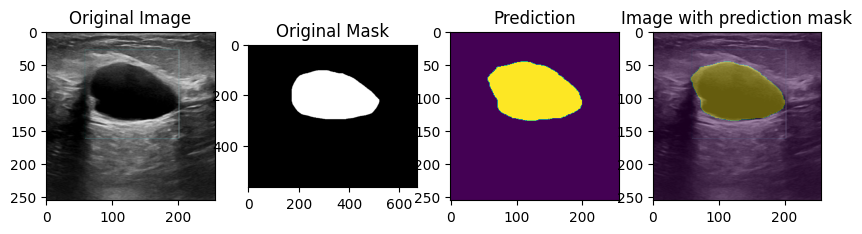

1/1 [==============================] - 0s 27ms/step


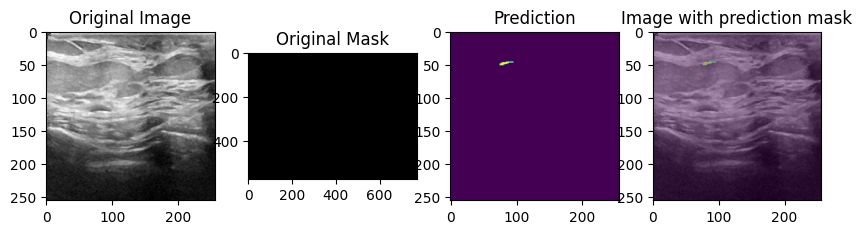

1/1 [==============================] - 0s 27ms/step


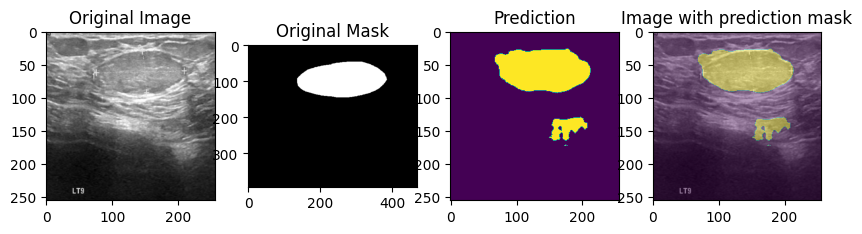

1/1 [==============================] - 0s 29ms/step


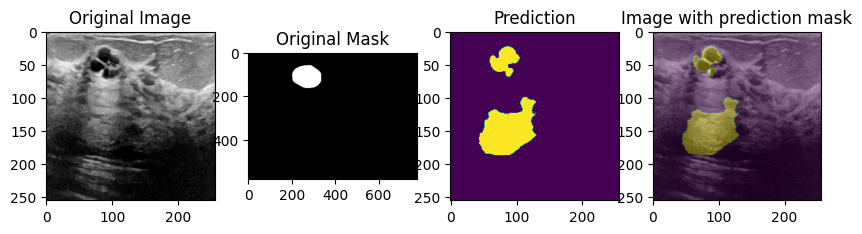

1/1 [==============================] - 0s 25ms/step


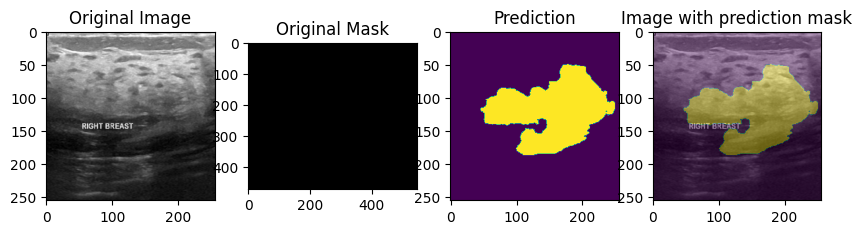

1/1 [==============================] - 0s 29ms/step


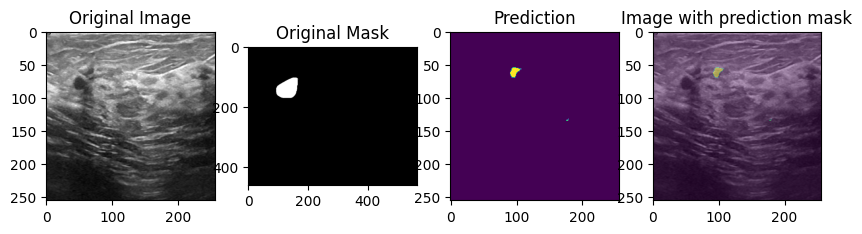

1/1 [==============================] - 0s 29ms/step


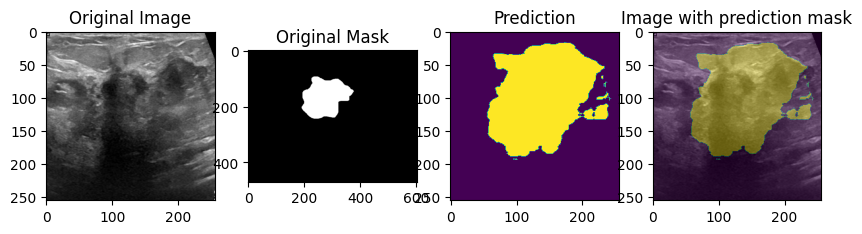

1/1 [==============================] - 0s 27ms/step


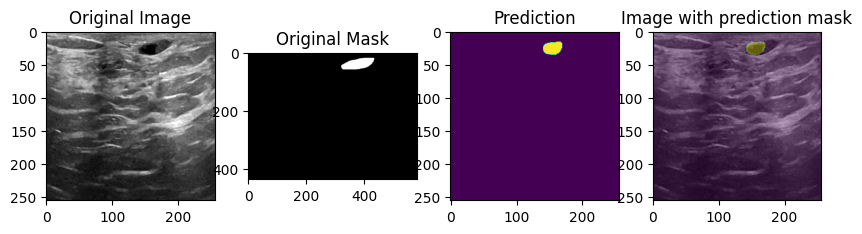

1/1 [==============================] - 0s 28ms/step


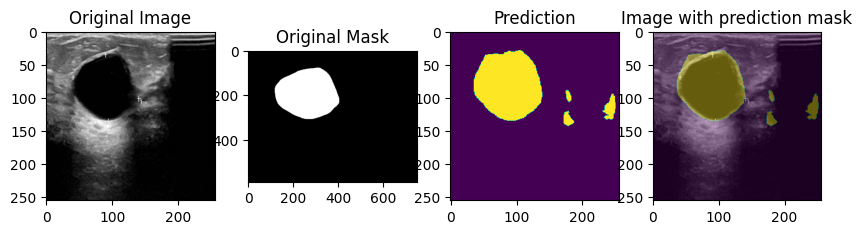

1/1 [==============================] - 0s 29ms/step


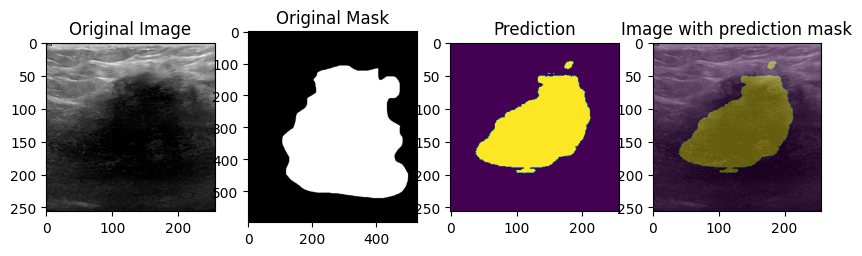

1/1 [==============================] - 0s 28ms/step


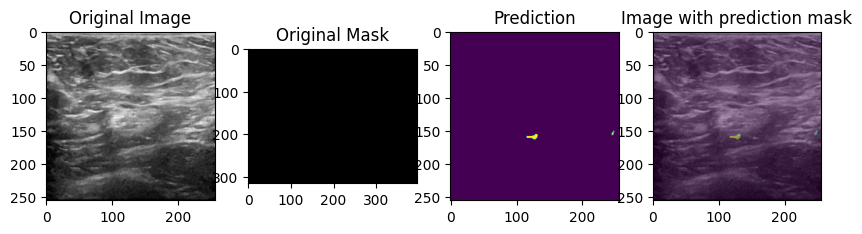

1/1 [==============================] - 0s 28ms/step


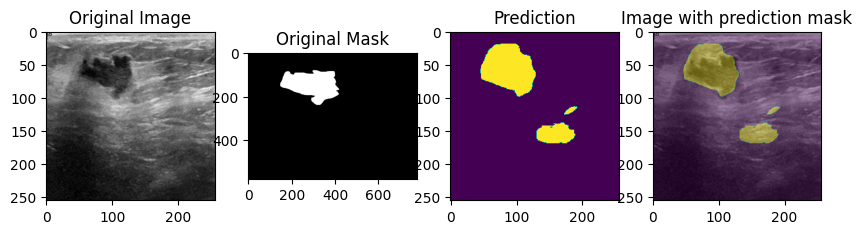

1/1 [==============================] - 0s 27ms/step


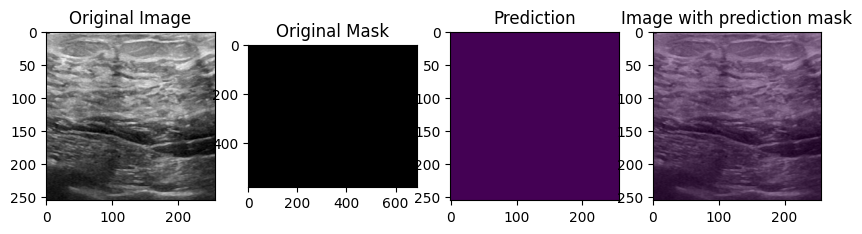

In [71]:
import cv2
for i in range(30):
    index=np.random.randint(1,len(data_test.index))
    img = cv2.imread(data_test['images'].iloc[index])
    img = cv2.resize(img ,(256, 256))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(10,10))
    plt.subplot(1,4,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,4,2)
    plt.imshow(np.squeeze(cv2.imread(data_test['masks'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,4,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.subplot(1,4,4)
    plt.imshow(np.squeeze(img))
    plt.imshow(np.squeeze(pred)>.5,alpha=0.4)
    plt.title('Image with prediction mask')
    plt.show()